In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import csv
from pathlib import Path

2023-09-19 07:21:45.537316: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 07:21:45.593009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 07:21:46.832278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Convolutional Layer

Test for the filter: How many neighbours does each cell have?

In [2]:
def get_neighbour_filter():
    neighb_filter= tf.keras.layers.Conv2D(1, (3, 3), padding='same',use_bias=False)
    filter_weights = np.ones((3,3))
    filter_weights[1][1] = 0
    neighb_filter.build((3, 3, 1))
    neighb_filter.set_weights([filter_weights.reshape((3,3,1,1))])
    return neighb_filter

<Axes: >

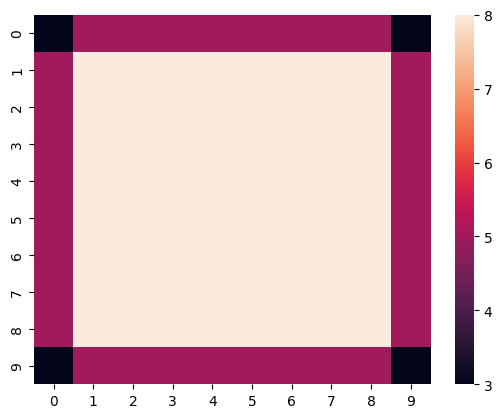

In [3]:
neighb_filter = get_neighbour_filter()
ones = np.ones((10, 10))
ones = ones.reshape(1, ones.shape[0], ones.shape[1], 1).astype('float32')
results = neighb_filter(ones)[0].numpy().squeeze()
sns.heatmap(results)

# Energy and magnetization time series

In [4]:
def time_series(folder):

    try:
        folder_path = Path(folder)
        reader = csv.DictReader(open(folder_path / "parameters.csv"))
        par_dict = next(reader) 
    except:
        raise ValueError("Invalid folder provided")

    n_rows = int(par_dict['Simulatiton Number'])
    n_cols = 3
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (9, n_rows * 2))

    fig.suptitle(f"Temperature: {par_dict['Temperature']} External Field: {par_dict['Magnetic Field']}", fontsize=18)
    
    plot_columns = ["Maze", "Energy", "Magnetization"]
    for ax, col in zip(axes[0], plot_columns):
        ax.set_title(col)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    for index in range(n_rows):
        # Maze Plot
        data = np.load(folder_path / f"output{index+1}" / "final.npy")
        axes[index][0].imshow(data)

        # Statistics
        columns = ['iter','energy','mag']
        df = pd.read_csv(folder_path / f"output{index+1}" / "data.csv", header=None, names=columns).set_index('iter')
        
        # Energy plot
        axes[index][1].plot(df.energy)
        
        # Magnetization plot
        axes[index][2].plot(df.mag)




## Low Temperature

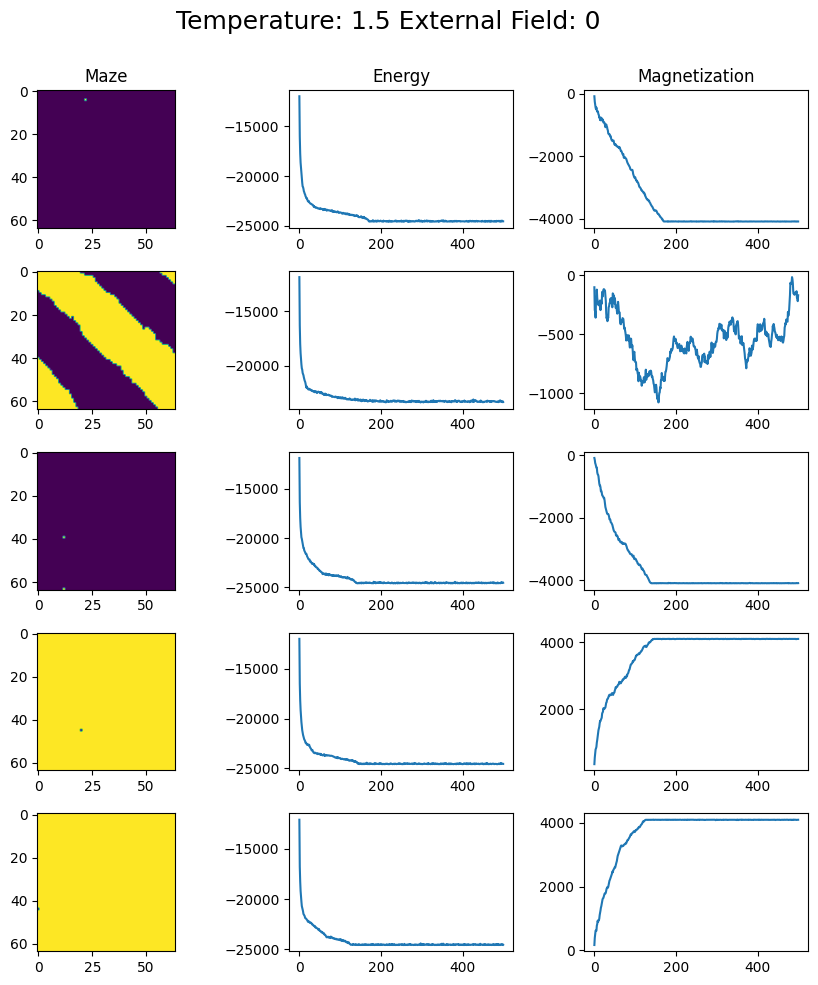

In [5]:
time_series("Rust/Demo/Low")

## High temperature

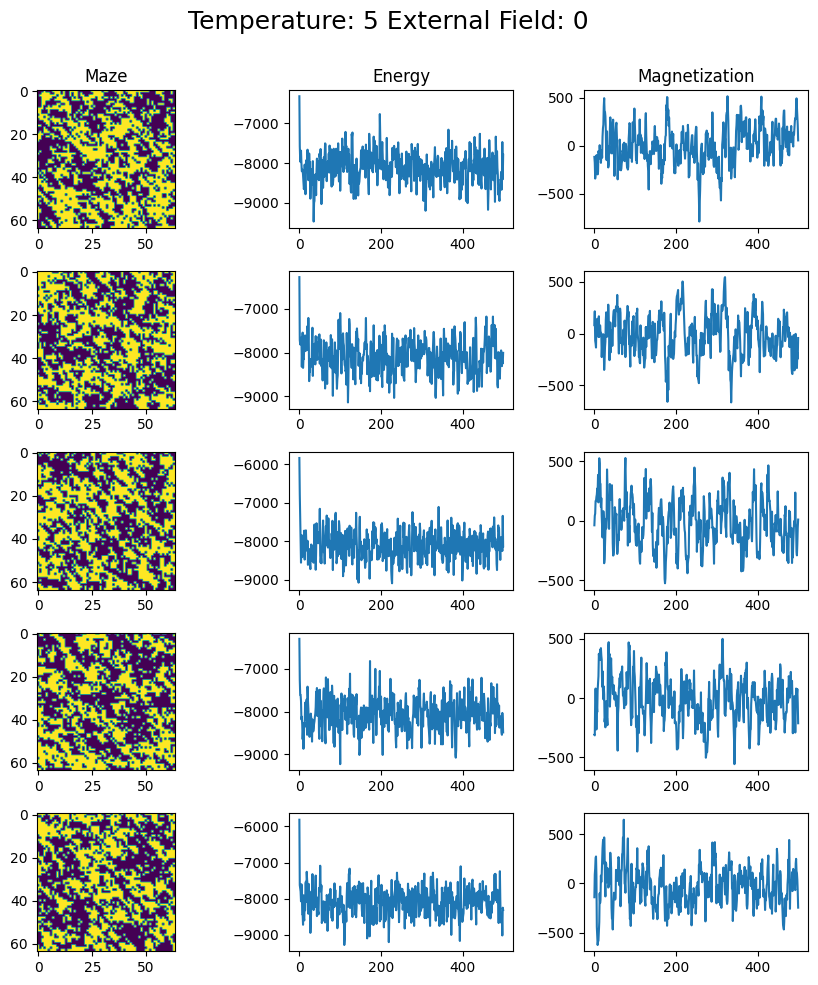

In [6]:
time_series("Rust/Demo/High")

## Around critical temperature

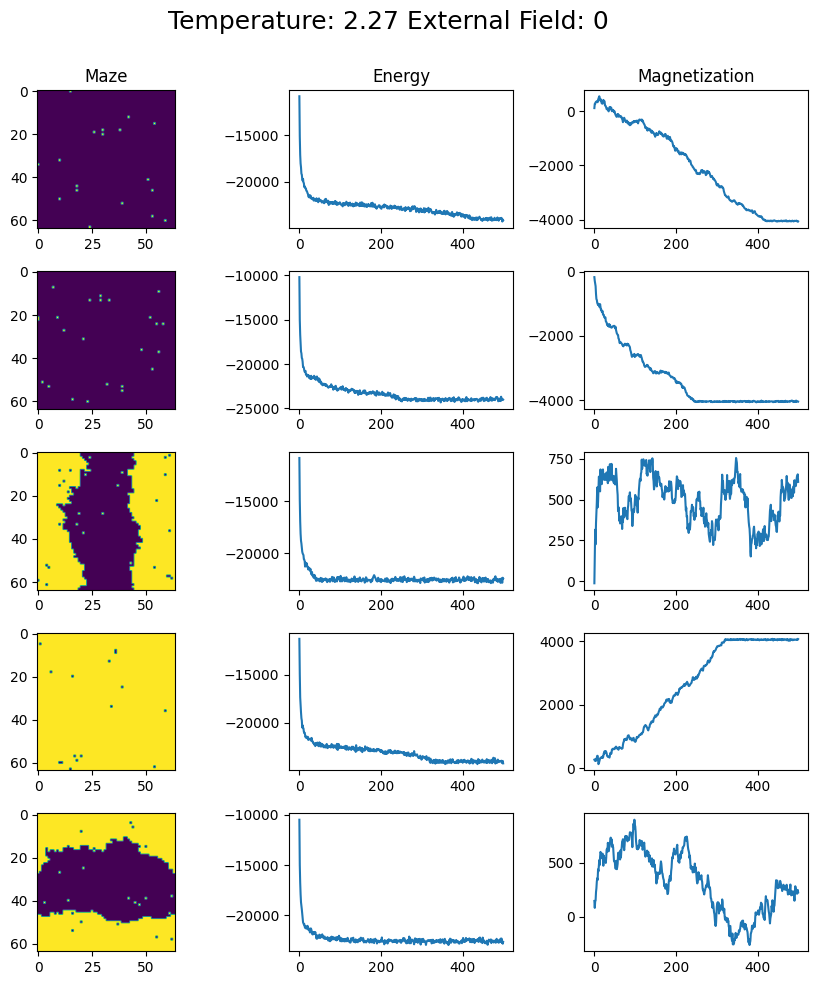

In [7]:
time_series("Rust/Demo/Crit")

## Positive Magnetic Field

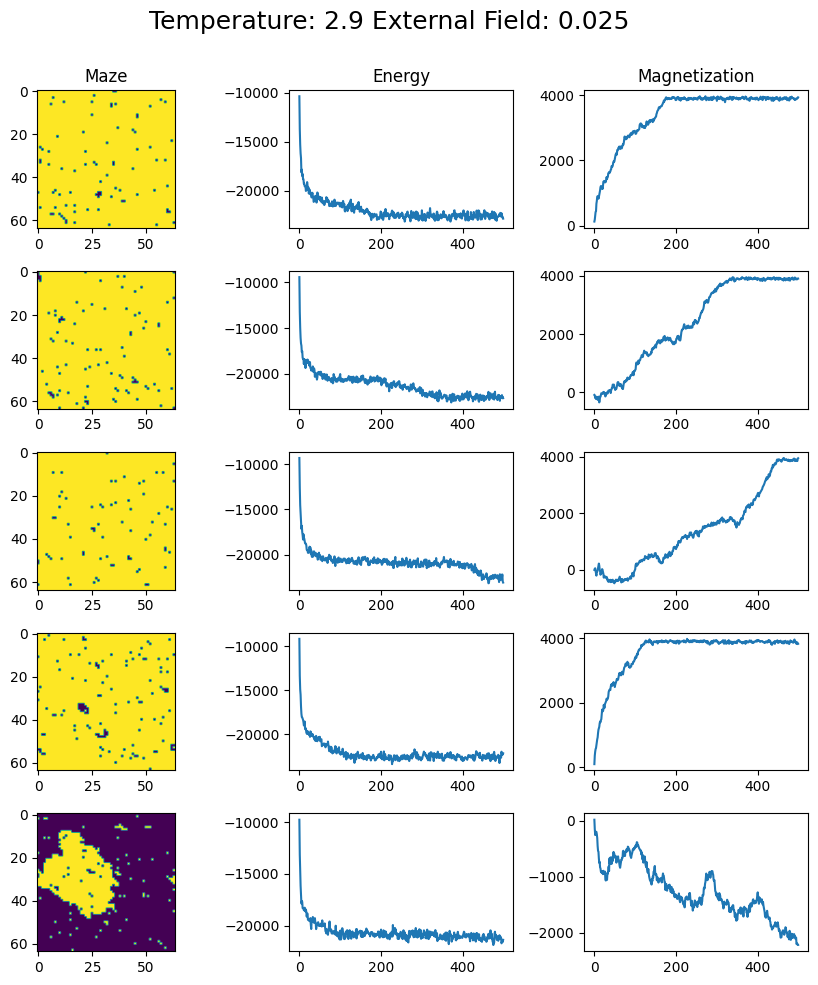

In [8]:
time_series("Rust/Demo/MagPositive/")

## Negative Magnetic Field

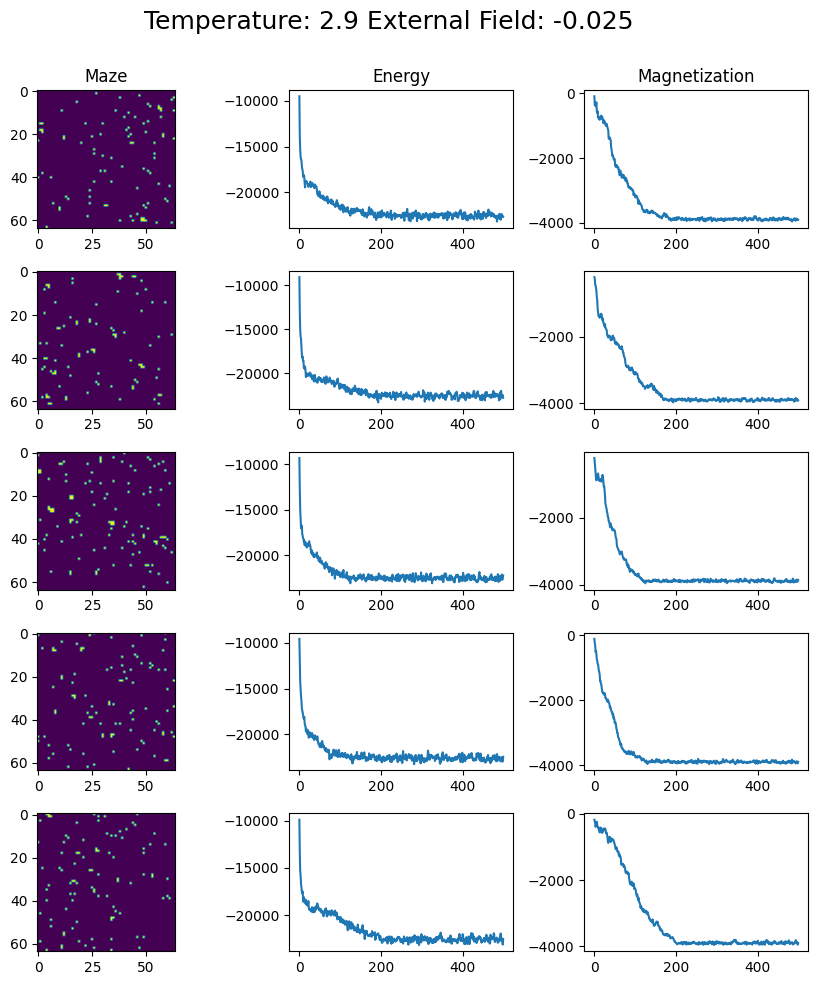

In [9]:
time_series("Rust/Demo/MagNegative/")

# Time of the simulation

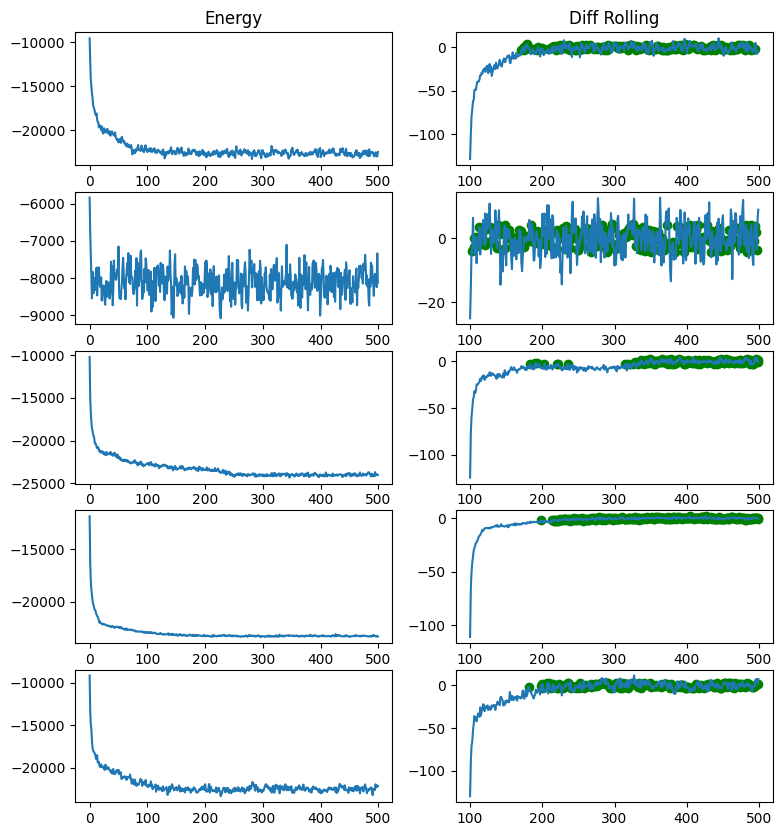

In [10]:
import os
import random

simulations  = []
for root, dir, files in os.walk("Rust/Demo"):

    if 'parameters.csv' in files:
        reader = csv.DictReader(open( root + "/parameters.csv" ))
        par_dict = next(reader)
        temp = float(par_dict['Temperature']) 
        simulations.append((f"{root}/{random.choice(dir)}", temp))

n_cols = 2
n_rows = len(simulations)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (9, n_rows * 2))

plot_columns = ["Energy", "Diff Rolling"]
for ax, col in zip(axes[0], plot_columns):
    ax.set_title(col)

for index, (sim, temp) in enumerate(simulations):
    # Statistics
    columns = ['iter','energy','mag']
    df = pd.read_csv(f"{sim}/data.csv", header=None, names=columns).set_index('iter')

    # Energy plot
    axes[index][0].plot(df.energy)
    
    # Energy plot
    energy_diff = df.energy.diff().rolling(100).mean()
    axes[index][1].plot(energy_diff)
    oscilating_points = energy_diff[energy_diff.abs() < 2.5 * np.log(1+temp)]
    axes[index][1].scatter(oscilating_points.index, oscilating_points, color = 'g')


